In [1]:
import numpy as np
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape
from keras.layers import Input
from keras.losses import mean_squared_error
from keras.optimizers import Adam

from utils import LossHistory, plotHistory, visualization
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.mnist import dataGenerator

Using TensorFlow backend.


# Parameters

In [2]:
num_class = 10
input_shape = (28, 28, 1)

batch_size = 32

data_augmentation = {
    'width_shift_range': 0.05,
    'height_shift_range': 0.05
}

# Dataset

In [3]:
trainGenerator = dataGenerator('train', batch_size=batch_size, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size)

11493376/11490434 [==============================] - 1s 0us/step


# Model

In [5]:
x = Input(shape=input_shape)
y = Input(shape=(num_class,))

encoder = Convolution2D(filters=256, kernel_size=(9, 9), activation='relu') (x)
encoder = PrimaryCaps(capsules=32, capsule_dim=8, kernel_size=(9, 9), strides=2, activation='relu', activation_caps=squash) (encoder)
encoder = Caps(capsules=10, capsule_dim=16, routings=3, activation_caps=squash) (encoder)

output = ClassesCaps(name='capsule') (encoder)

decoder = Mask() (encoder, y_true=y)
decoder = Dense(512, activation='relu') (decoder)
decoder = Dense(1024, activation='relu') (decoder)
decoder = Dense(784, activation='sigmoid') (decoder)
decoder = Reshape((input_shape), name='reconstruction') (decoder)

model_training = Model(inputs=[x, y], outputs=[output, decoder])
model = Model(inputs=x, outputs=output)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 256)       20992     
_________________________________________________________________
primary_caps_1 (PrimaryCaps) (None, 1152, 8)           5308672   
_________________________________________________________________
caps_1 (Caps)                (None, 10, 16)            1474560   
_________________________________________________________________
capsule (ClassesCaps)        (None, 10)                0         
Total params: 6,804,224
Trainable params: 6,804,224
Non-trainable params: 0
_________________________________________________________________


# Training

In [7]:
model_training.compile(loss=[margin(), mean_squared_error],
                        loss_weights=[1, 0.0005],
                        optimizer=Adam(lr=1e-3),
                        metrics={'capsule': 'accuracy'})

In [8]:
history = LossHistory(metrics=('loss', 'capsule_loss', 'reconstruction_loss', 'capsule_acc'))
hist = model_training.fit_generator(trainGenerator,
                                    steps_per_epoch=60000 // batch_size,
                                    epochs=10,
                                    validation_data=testGenerator,
                                    validation_steps=10000 // batch_size,
                                    callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 276s 5ms/step - loss: 0.0077 - capsule_loss: 0.0076 - reconstruction_loss: 0.0787 - capsule_acc: 0.4642 - val_loss: 2.7513e-05 - val_capsule_loss: 6.4220e-09 - val_reconstruction_loss: 0.0550 - val_capsule_acc: 0.6170
Epoch 2/10
60000/60000 [==============================] - 272s 5ms/step - loss: 2.8936e-05 - capsule_loss: 1.8290e-06 - reconstruction_loss: 0.0542 - capsule_acc: 0.4711 - val_loss: 2.6703e-05 - val_capsule_loss: 1.1972e-08 - val_reconstruction_loss: 0.0534 - val_capsule_acc: 0.5631
Epoch 3/10
60000/60000 [==============================] - 273s 5ms/step - loss: 4.9625e-05 - capsule_loss: 2.2688e-05 - reconstruction_loss: 0.0539 - capsule_acc: 0.4759 - val_loss: 2.8441e-05 - val_capsule_loss: 1.2359e-06 - val_reconstruction_loss: 0.0544 - val_capsule_acc: 0.5537
Epoch 4/10
60000/60000 [==============================] - 272s 5ms/step - loss: 3.0805e-05 - capsule_loss:

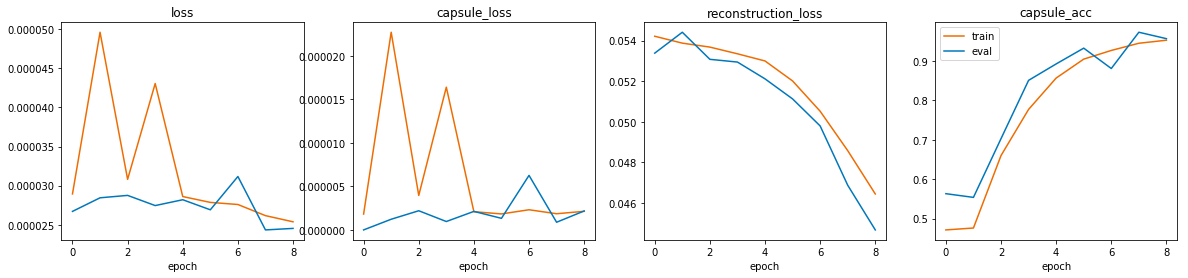

In [9]:
plotHistory(history.metrics)

# Visualization

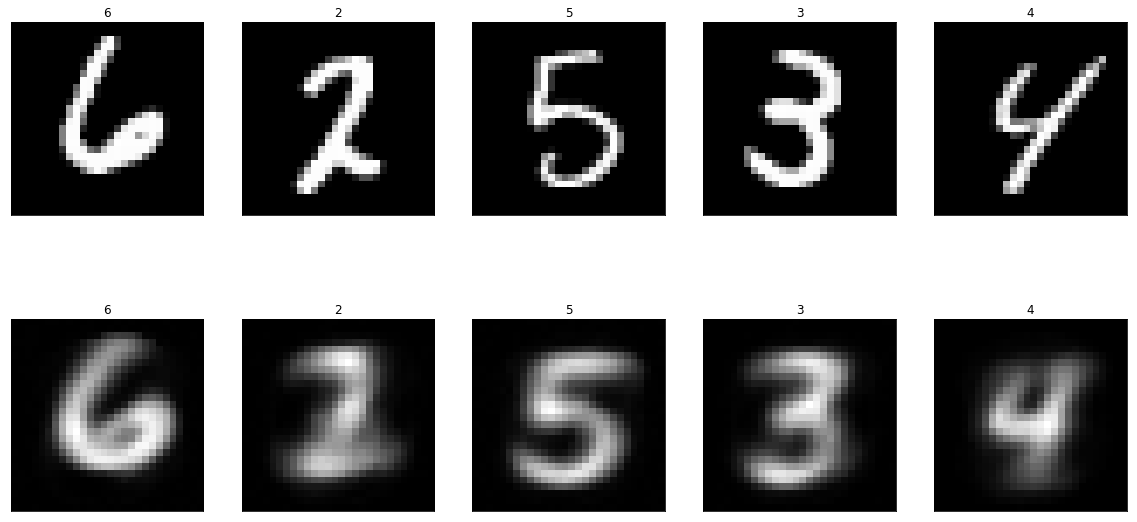

In [10]:
n_image = 5

display_index = np.random.choice(x_test.shape[0], n_image)
images = np.array([x_test[i] for i in display_index])
labels = np.array([y_test[i] for i in display_index])

classes, reconstructions = model_training.predict([images, labels])

labels = np.argmax(labels, axis=1)
predictions = np.argmax(classes, axis=1)
images = images.reshape(-1, 28, 28)
reconstructions = reconstructions.reshape(-1, 28, 28)

visualization((images, labels), (reconstructions, predictions))